# Sinking Particulate Organic Carbon

## Science questions
1. How do different models parameterise the sink of organic carbon to the deep ocean? Do they follow Martin's b? Is the shape of the decline with depth set by the biogeochemical model component or an artifact of the model run (e.g. more influenced by physical circulation than the BGC model component)?

2. How does the sink of POC change in the future? Is it consistent amongst models?

### Methods

The Cloud was used to extract sinking organic carbon `expc` (mol m-2 s-1) for a historical and future (ssp585) run using `r1i1p1f1` and annual model outputs (`Oyr`). IPSL-CM6A-LR is the only model with both historical and future runs for `expc` output using the default criteria (`grid_label='gn'`). GFDL-CM4 satisfies criteria when `grid_label` is not specified. 

In this notebook IPSL is used but this has both latitude and longitude run from 0 - 360 degrees, this is ignored...for now!

There are a few warning messages throught out which I have turned off, beware!

In [53]:
%matplotlib inline

import xarray as xr
import intake
import numpy as np

# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util 

import warnings
warnings.filterwarnings("ignore")

In [54]:
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")

In [55]:
import pprint 
uni_dict = col.unique(['source_id', 'experiment_id', 'table_id'])
#pprint.pprint(uni_dict, compact=True)

In [56]:
cat = col.search(experiment_id=['historical', 'ssp585'], table_id='Oyr', variable_id='o2', grid_label='gn')

In [60]:
models = set(uni_dict['source_id']['values']) # all the models

for experiment_id in ['historical', 'ssp585']:
    query = dict(experiment_id=experiment_id, table_id='Oyr', 
                 variable_id='expc', grid_label='gn')  
    cat = col.search(**query)
    models = models.intersection({model for model in cat.df.source_id.unique().tolist()})

# ensure the CESM2 models are not included (oxygen was erroneously submitted to the archive)
models = models - {'CESM2-WACCM', 'CESM2'}

models = list(models)
models

['IPSL-CM6A-LR']

Only one model (IPSL) satisfies the criteria. **Future step** - remove `grid_label` and analyse GFDL model.

In [61]:
cat = col.search(experiment_id=['historical', 'ssp585'], table_id='Oyr', 
                 variable_id='expc', grid_label='gn', member_id='r1i1p1f1', source_id=models)
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
7385,CMIP,IPSL,IPSL-CM6A-LR,historical,r1i1p1f1,Oyr,expc,gn,gs://cmip6/CMIP/IPSL/IPSL-CM6A-LR/historical/r...,NaN
26195,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp585,r1i1p1f1,Oyr,expc,gn,gs://cmip6/ScenarioMIP/IPSL/IPSL-CM6A-LR/ssp58...,NaN


In [62]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False}, 
                                cdf_kwargs={'chunks': {}, 'decode_times': False})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 2 group(s)


In [40]:
dset_dict.keys()

dict_keys(['CMIP.IPSL.IPSL-CM6A-LR.historical.Oyr.gn', 'ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp585.Oyr.gn'])

### Plot historical POC in the surface and 'deep'

Extract historical model output

In [63]:
hist = dset_dict['CMIP.IPSL.IPSL-CM6A-LR.historical.Oyr.gn']

In [42]:
# Convert from mol C m-2 s-1 to mg C m-2 d-1
hist_day = hist * (60*60*24) * 12 * 1000

Plot last timestep (2015) from historical output. Really high `expc` values in coastal regions and lakes so `expc` is logged.

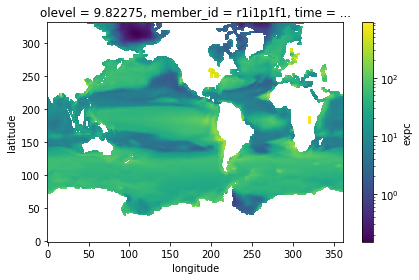

In [69]:
import matplotlib.colors as colors
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
hist_day.expc.isel(olevel = 7, time=164).plot(norm=colors.LogNorm())
plt.title('Surface (10 m) POC (mg C m-2 d-1) in 2015')
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.tight_layout()
plt.show()

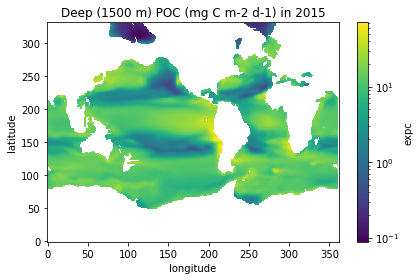

In [66]:
# Plot
fig, ax = plt.subplots()
hist_day.expc.isel(olevel = 50, time=164).plot(norm=colors.LogNorm())
plt.title('Deep (1500 m) POC (mg C m-2 d-1) in 2015')
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.tight_layout()
plt.show()

### Plot future surface POC

Extract future (ssp585) model output and plot as above

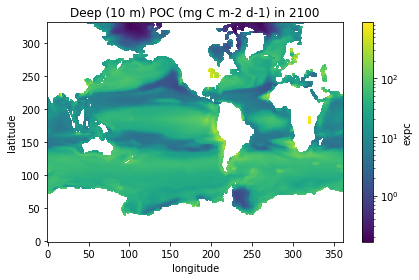

In [70]:
ssp585 = dset_dict['ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp585.Oyr.gn']
# Convert from mol C m-2 s-1 to mg C m-2 d-1
ssp585_day = hist * (60*60*24) * 12 * 1000
# Plot
fig, ax = plt.subplots()
ssp585_day.expc.isel(olevel = 7, time=84).plot(norm=colors.LogNorm())
plt.title('Deep (10 m) POC (mg C m-2 d-1) in 2100')
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.tight_layout()
plt.show()
#ssp585_day.expc.isel(olevel = 7, time=85).plot()

### POC with depth

Look at cross-section (north - south) with depth through Atlantic (lon = 260 deg, according to the IPSL grid)

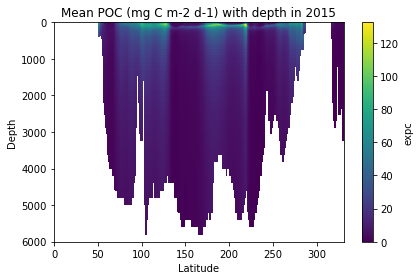

In [68]:
# Plot through Atlantic
roi = dict(x=260, time=164)

fig, ax = plt.subplots()
hist_day.expc.isel(**roi).plot(yincrease=False)
plt.title('Mean POC (mg C m-2 d-1) with depth in 2015')
plt.ylabel('Depth')
plt.xlabel('Latitude')
plt.tight_layout()
plt.show()

### Predicted change in sinking POC from historic runs to future

A 10-yr mean is calculated for both model runs. So the years compared is the mean climatology from 2005-2015 and 2090-2100.

In [71]:
tmp = (hist_day.isel(time=(164-np.arange(10))).mean('time') - 
           ssp585_day.isel(time=(85 - np.arange(10))).mean('time'))

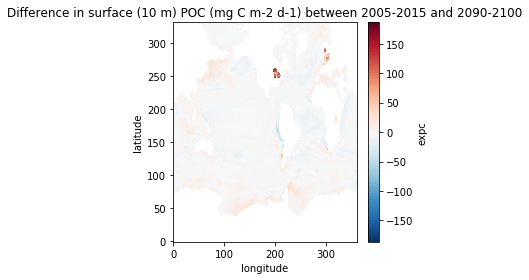

In [72]:
fig, ax = plt.subplots()
tmp.expc.isel(olevel = 7).plot()
plt.title('Difference in surface (10 m) POC (mg C m-2 d-1) between 2005-2015 and 2090-2100')
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.tight_layout()
plt.show()
#tmp.expc.isel(olevel = 7).plot() # Difference in sinking carbon at 10 m

Can't log the data as negative values. Ideally would remove all cells with coordinates for the USA lakes and Mediterranean throughout the whole analysis. For the plot below although colours are brighter it is because the lakes/Med arent 5000 m deep and the actually change is an order of magnitude less than the max change in the above plot.

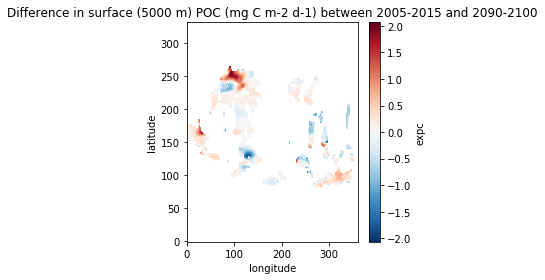

In [48]:
fig, ax = plt.subplots()
tmp.expc.isel(olevel = 70).plot() # Difference in sinking carbon 5000 m
plt.title('Difference in surface (5000 m) POC (mg C m-2 d-1) between 2005-2015 and 2090-2100')
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.tight_layout()
plt.show()

### Change in POC with depth at isolated coordinates

To Marin Curve or to not, that is the question!

In [49]:
# Extract 10-yr averages
hist_ten = hist_day.isel(time=(164-np.arange(10))).mean('time')
ssp585_ten = ssp585_day.isel(time=(85 - np.arange(10))).mean('time')

In [50]:
# extract one depth profile for North Atlantic
hist_atl = hist_ten.isel(x=250, y=250, member_id=0)

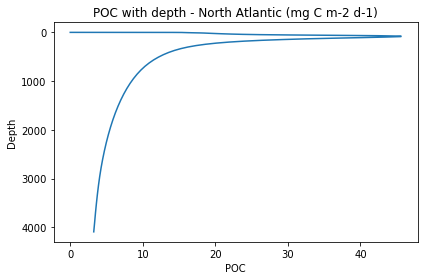

In [51]:
# Atlantic profile of POC with depth (lon = 250, lat = 250 - IPSL grid)

fig, ax = plt.subplots()
hist_atl.expc.isel().plot.line(y='olevel',yincrease=False)
plt.title('POC with depth - North Atlantic (mg C m-2 d-1)')
plt.ylabel('Depth')
plt.xlabel('POC')
plt.tight_layout()
plt.show()


POC increases with depth from 0 - 70 m, i.e. within the mixed layer and then declines with depth as we would expect.

Something to consider is do all models have the same increase in the mixed layer? At what point do the models then set the decline in POC from? Is it going to be easy for us to identify, i.e. will it always be from the same depth? In IPSL it appears to always be 70 m.

### Historical POC mesopelagic decline with depth at two Atlantic sites

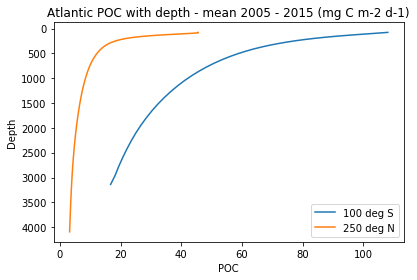

In [52]:
hist_atl = hist_ten.isel(x=250, member_id=0)

# Atlantic profile of POC with depth (lon = 250 - IPSL grid)

fig, ax = plt.subplots()
hist_atl.expc.isel(olevel=74 - np.arange(54), y=[100,250]).plot.line(y='olevel',yincrease=False)
plt.title('Atlantic POC with depth - mean 2005 - 2015 (mg C m-2 d-1)')
plt.ylabel('Depth')
plt.xlabel('POC')
plt.tight_layout()
plt.legend(['100 deg S', '250 deg N'])
plt.show()

### Some future work

1. Re-do with GFDL
2. Plot global maps without high POC values in the lakes and Med
3. Compare shapes of curves from around the globe - Martin curve, z* or other?
4. Look at how these curves change in the future
5. Use Cartopy, so re-grid IPSL
6. Look at all of this with other models.
